In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [89]:
data = pd.read_csv('./output_columns/total.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,energy_production
0,2022-01-01,171965
1,2022-01-02,171026
2,2022-01-03,206393
3,2022-01-04,226307
4,2022-01-05,205385


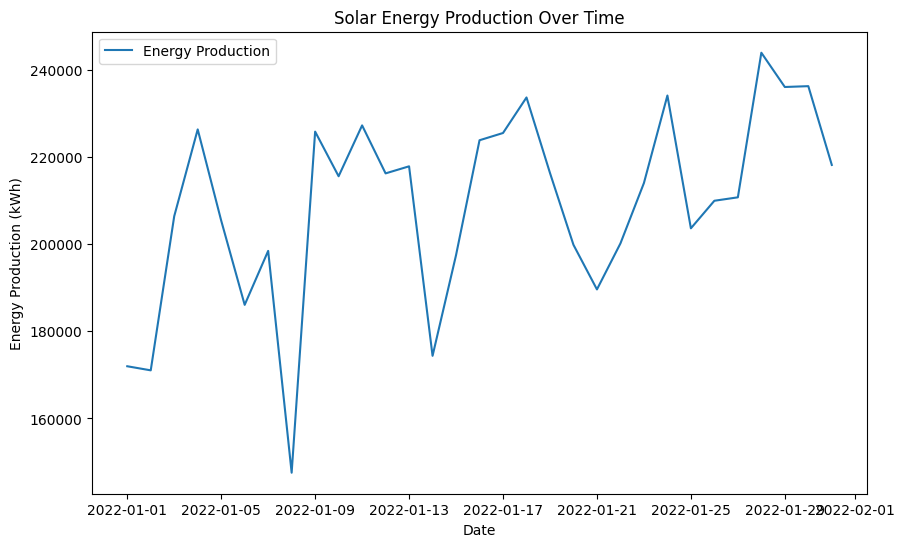

In [90]:
# Plot the solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Solar Energy Production Over Time')
plt.legend()
plt.show()

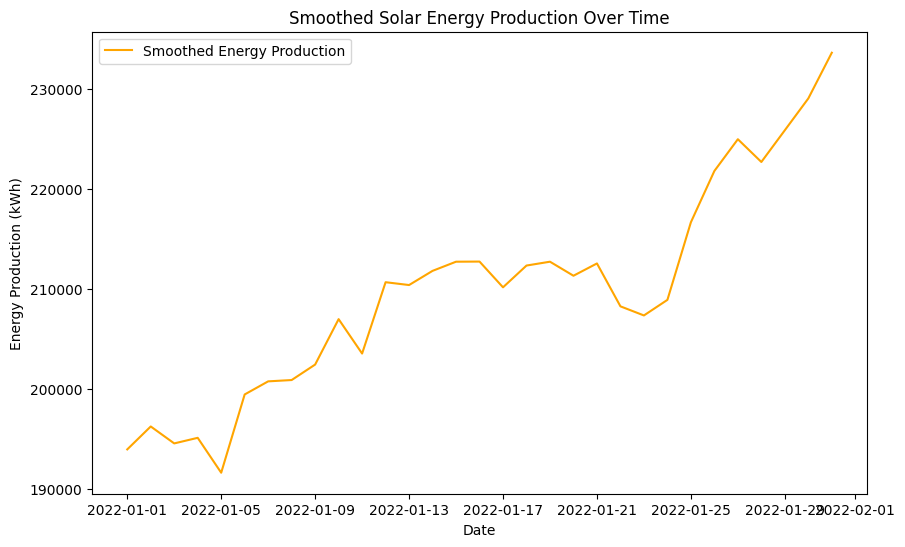

,date,energy_production
0,2022-01-01,193922.750000
1,2022-01-02,196215.200000
2,2022-01-03,194521.500000
3,2022-01-04,195080.857143
4,2022-01-05,191591.000000
5,2022-01-06,199416.000000
6,2022-01-07,200725.571429
7,2022-01-08,200857.428571
8,2022-01-09,202405.142857
9,2022-01-10,206946.000000


In [91]:
# Apply a rolling mean to smooth the data with min_periods to avoid NaN values
data['energy_production'] = data['energy_production'].rolling(window=7, center=True, min_periods=1).mean()

# Plot the smoothed solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production', color='orange')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

data.head(32)

In [92]:
# Partition the data into train_data and test_data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

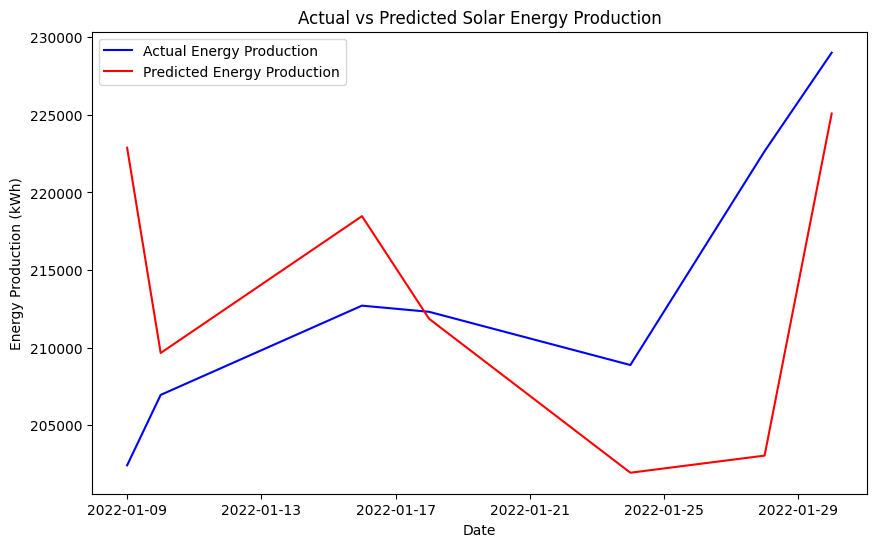

In [93]:
# Convert 'date' to ordinal numbers for regression
train_data['date_ordinal'] = pd.to_datetime(train_data['date']).map(datetime.toordinal)
test_data['date_ordinal'] = pd.to_datetime(test_data['date']).map(datetime.toordinal)

# Split target (y) and feature (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['date_ordinal']]

y_test = test_data['energy_production']
X_test = test_data[['date_ordinal']]

# Define and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
predicted_values = linear_model.predict(X_test)

# Sort the test data by date for continuous plotting
sorted_test_data = test_data.sort_values(by='date')
sorted_predicted_values = predicted_values[sorted_test_data.index.argsort()]

# Plot actual vs predicted energy production with correct date formatting
plt.figure(figsize=(10,6))
plt.plot(sorted_test_data['date'], sorted_test_data['energy_production'], label='Actual Energy Production', color='blue')
plt.plot(sorted_test_data['date'], sorted_predicted_values, label='Predicted Energy Production', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production')
plt.legend()
plt.show()


In [94]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')

RMSE: 4353.131167236626
MAE: 3091.6709880833764
R² Score: 0.7419205886150342
